# Example notebook 1

This exampple illustrates the usage of xarray-based data structures for calculating the Beer-Lambert transformation.

In [1]:
import cedalion
import cedalion.nirs
import cedalion.xrutils
import cedalion.xrutils as xrutils
import numpy as np
import xarray as xr
import pint
import matplotlib.pyplot as p
import scipy.signal
import os.path
xr.set_options(display_max_rows=3, display_values_threshold=50)
np.set_printoptions(precision=4)

### Loading raw CW-NIRS data from a SNIRF file

This notebook uses a finger-tapping dataset in BIDS layout provided by Rob Luke. Download it [here](https://github.com/rob-luke/BIDS-NIRS-Tapping) and point the variable `DATADIR` to its location.

In [2]:
DATADIR = "../../data/BIDS-NIRS-Tapping"

Load amplitude data from the snirf file.

In [3]:
elements = cedalion.io.read_snirf(
    os.path.join(DATADIR, "sub-01/nirs/sub-01_task-tapping_nirs.snirf")
)
element = elements[0] # there is only one NirsElement in this snirf file...
amp = element.data[0] # ... which holds amplitude data

# restrict to first 60 seconds and fill in missing units
amp = amp.sel(time=amp.time < 60)
amp = amp.pint.dequantify().pint.quantify("V")
geo3d = element.geo3d


### Amplitude data

In [4]:
display(amp.round(4))

Magnitude,[[[0.0914 0.091 0.091 ... 0.0903 0.0902 0.0899] [0.1857 0.1864 0.1837 ... 0.1849 0.185 0.1847]] [[0.2275 0.2297 0.2261 ... 0.2241 0.2243 0.2257] [0.6355 0.6377 0.6298 ... 0.6223 0.6237 0.6272]] [[0.1065 0.1066 0.1053 ... 0.1065 0.1062 0.1056] [0.2755 0.2762 0.2727 ... 0.2737 0.2742 0.276]] ... [[0.2028 0.1997 0.2005 ... 0.1998 0.2007 0.2026] [0.4666 0.4554 0.4562 ... 0.4482 0.4511 0.4541]] [[0.4885 0.4802 0.4818 ... 0.5005 0.5036 0.5045] [0.8458 0.826 0.826 ... 0.8386 0.8441 0.8475]] [[0.6305 0.6284 0.6287 ... 0.6373 0.638 0.6392] [1.2286 1.2206 1.219 ... 1.2232 1.2259 1.2278]]]
Units,volt


### Montage information

The `geo3d` DataArray maps labels to 3D positions, thus storing the location of optodes and landmarks.

In [5]:
display_labels = ["S1", "S2", "D1", "D2", "NASION"] # for brevity show only these
geo3d.round(5).sel(label=display_labels)

Magnitude,[[-0.04161 0.0268 0.1299] [-0.06477 0.05814 0.09084] [-0.03762 0.06323 0.11573] [-0.04134 -0.01178 0.13495] [0.0 0.11405 -0.0]]
Units,meter


To obtain channel distances, we can lookup `amp`'s source and detector coordinates in `geo3d`,
subtract these and calculate the vector norm.

In [6]:
dists = xrutils.norm(geo3d.loc[amp.source] - geo3d.loc[amp.detector], dim="pos")
display(dists.round(3))

Magnitude,[0.039 0.039 0.041 0.008 0.037 0.038 0.037 0.007 0.04 0.037 0.008 0.041 0.034 0.008 0.039 0.039 0.041 0.008 0.037 0.037 0.037 0.008 0.04 0.037 0.007 0.041 0.033 0.008]
Units,meter


### Beer-Lambert transformation

Specify differential path length factors (DPF). Obtain a matrix of tabulated extinction coefficients for the wavelengths of our dataset and calculate the inverse.

In [7]:
dpf = xr.DataArray([6., 6.], dims="wavelength", coords={"wavelength" : [760., 850.]})

E = cedalion.nirs.get_extinction_coefficients("prahl", amp.wavelength)
Einv = cedalion.xrutils.pinv(E)
display(Einv.round(4))

Magnitude,[[-0.0024 0.0037] [0.0055 -0.0021]]
Units,millimeter molar


In [8]:
optical_density =  -np.log( amp / amp.mean("time"))

conc = Einv @ (optical_density / ( dists * dpf))

display(conc.pint.to("micromolar").round(4))

Magnitude,[[[-0.0538 -0.1835 0.1612 ... -0.0725 -0.1064 -0.0939] [-0.1971 -0.1772 -0.0504 ... 0.1388 0.0943 0.0257] [0.0052 -0.0338 0.1269 ... 0.1558 0.0805 -0.1094] ... [-0.4716 -0.084 -0.0781 ... 0.2843 0.1805 0.1309] [-0.6011 -0.1653 -0.124 ... -0.0753 -0.1786 -0.2662] [-1.1848 -0.5717 -0.392 ... -0.076 -0.2826 -0.3658]] [[-0.168 -0.0692 -0.2042 ... -0.0249 0.0083 0.0364] [-0.0429 -0.1653 -0.0254 ... 0.0097 0.0158 -0.0304] [-0.0471 -0.0485 0.0284 ... -0.1066 -0.0428 0.0851] ... [0.0045 0.0366 -0.0132 ... -0.1122 -0.1236 -0.2155] [0.3211 0.3949 0.3327 ... -0.2165 -0.264 -0.2554] [0.6814 0.6478 0.554 ... -0.4091 -0.3963 -0.487]]]
Units,micromolar


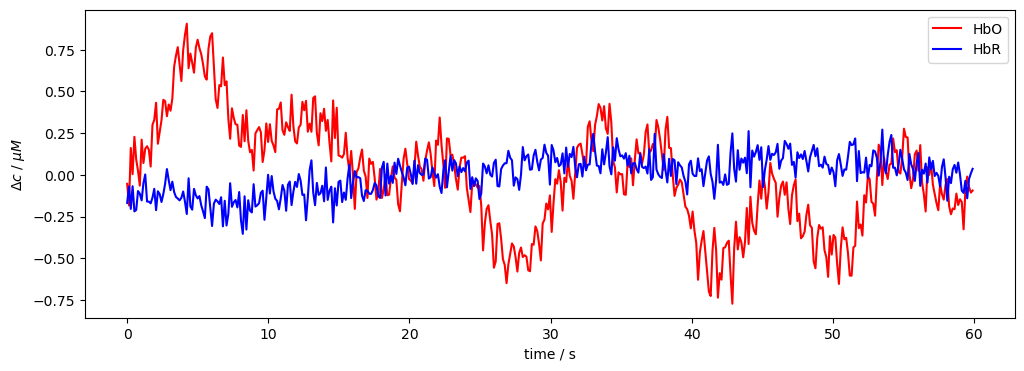

In [9]:
f,ax = p.subplots(1,1, figsize=(12,4))
ax.plot( conc.time, conc.sel(channel="S1D1", chromo="HbO").pint.to("micromolar"), "r-", label="HbO")
ax.plot( conc.time, conc.sel(channel="S1D1", chromo="HbR").pint.to("micromolar"), "b-", label="HbR")
p.legend()
ax.set_xlabel("time / s")
ax.set_ylabel("$\Delta c$ / $\mu M$");